In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import torch
import torch.functional as F
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import defaultdict
from copy import deepcopy

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import MIMIC
from lib.eval import bootstrap

In [381]:
# task = 'Edema'
task = 'Cardiomegaly'
m = MIMIC(task)
len(m)

316135 unknown Cardiomegaly value in mimic data


108785

In [383]:
task = 'Edema'
# task = 'Cardiomegaly'
m = MIMIC(task)
len(m)

317410 unknown Edema value in mimic data


107510

In [354]:
bootstrap(lambda y, yhat: np.corrcoef(y, yhat)[0,1], np.array(m.df['is_male']), np.array(m.df[task]))

(-0.030736366195947915, -0.019116491267480558)

In [355]:
m.df[['is_male', task]].corr()

,is_male,Cardiomegaly
is_male,1.000000,-0.024781
Cardiomegaly,-0.024781,1.000000


In [4]:
def MI(x, y):
    '''
    mutual information between two binary attributes
    x and y are two equal length list
    '''
    def H(p):
        return - p * np.log(p) - (1-p) * np.log(1-p)
    
    px, py = x.mean(), y.mean()
    py_x, py_notx = y[x==1].mean(), y[x==0].mean()
    return H(py) - (px * H(py_x) + (1-px) * H(py_notx)), H(px), H(py)

mi, ht, hm = MI(m.df[task], m.df['is_male'])
print(mi, ht, hm)
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')

4.462104700964087e-05 0.6725106982356779 0.6867981495124605
I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


In [68]:
n_samples = len(np.unique(m.df.subject_id))
n_males = len(np.unique(m.df[m.df.gender=='M'].subject_id))
n_females = len(np.unique(m.df[m.df.gender=='F'].subject_id))
print(f'{len(m.df)} x-rays, {len(np.unique(m.df.pt_id))} studies')
print(f'{n_samples} patients, {n_males} ({n_males/n_samples*100:.2f}%) male, {n_females} ({n_females/n_samples*100:.2f}%) female')

107510 x-rays, 62697 studies
22738 patients, 11307 (49.73%) male, 11431 (50.27%) female


In [66]:
print(f"P({task}) = {m.df[task].mean():.2f}")
print(f"P({task}|male) = {m.df[m.df.gender=='M'][task].mean():.2f}")
print(f"P({task}|female) = {m.df[m.df.gender=='F'][task].mean():.2f}")

P(Edema) = 0.60
P(Edema|male) = 0.60
P(Edema|female) = 0.61


In [55]:
m.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Support Devices,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,17,35,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50578979,train,10000935,F,52,2182,2008 - 2010,NaN
1,26,52,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58219844,train,10000935,F,52,2182,2008 - 2010,NaN
2,27,53,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
3,28,55,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
4,32,62,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,54935705,train,10000980,F,73,2186,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107505,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN
107506,425896,729288,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107507,425897,729289,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107508,425898,729290,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN


In [8]:
def subsample_gender(df, threshold):
    '''
    df is the mimic dataset
    remove male negative and female positive
    '''
    z = np.random.rand(len(df))
    drop = (df['gender'] == 'M') * (df[m.task] == 0) + (df['gender'] == 'F') * (df[m.task] == 1)
    drop = drop * (z <= threshold)
    new_df = df[~drop]
    return new_df
    
subsample_gender(m.df, 1)[['is_male', task]].corr()

,is_male,Edema
is_male,1.0,1.0
Edema,1.0,1.0


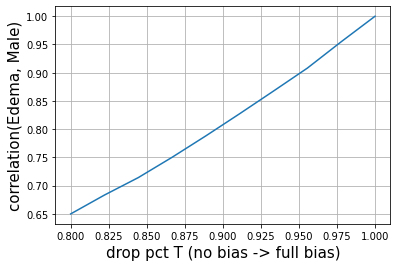

In [247]:
x = np.linspace(0.8, 1, 10)
correlation = [subsample_gender(m.df, t)[['is_male', task]].corr().iloc[0, 1] for t in x]
plt.plot(x, correlation, label=f'correlation({task}, male)')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel(f'correlation({task}, Male)', fontsize=15)
plt.grid()
# plt.legend(fontsize=15)
plt.show()

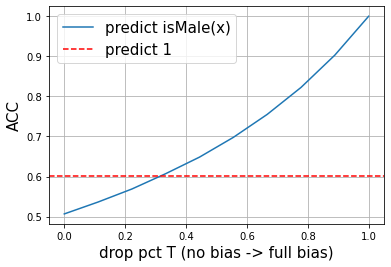

In [248]:
def ACC_male(m, t, task, f):
    '''
    accuracy of using isMale to predict task when subsampling at threshold t
    '''
    df = subsample_gender(m.df, t)
    return f(df[task], df['gender'] == 'M')

reduce_fn = metrics.accuracy_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('ACC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

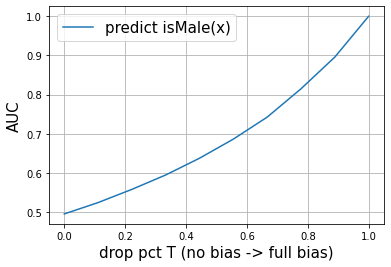

In [249]:
reduce_fn = metrics.roc_auc_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
# plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

# Per group investigation (automated)

In [32]:
methods = ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)', 'finetune', 'ugrad']

def get_approach_name(fn, alpha):
    name = fn.split('/')[-1].split('_')[0]
    if name == 'ccm' and alpha == None:
        return methods[6]
    elif name == 'ccm' and alpha != 0:
        return methods[0]    
    elif name == 'ccmr':
        return methods[1]
    elif name == 'ccm' and alpha == 0:
        return methods[2]
    elif name == 'cbm':
        return methods[3]
    elif name == 'standard':
        return methods[4]
    elif name == 'finetune':
        return methods[5]    
    else:
        raise Exception(f"not defined name {name}")

In [3]:
results = {m: defaultdict(dict) for m in methods} # results[method][x][key]

In [4]:
source = 'Cardiomegaly'
target = 'Edema'
m_s = MIMIC(source)
m_t = MIMIC(target)

316135 unknown Cardiomegaly value in mimic data
317410 unknown Edema value in mimic data


In [12]:
m_s.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_male
24,24,49,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,56522600,train,10000935,F,52,2182,2008 - 2010,NaN,0.0
25,25,51,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,56522600,train,10000935,F,52,2182,2008 - 2010,NaN,0.0
38,38,74,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58206436,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
39,39,76,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58636672,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
40,40,78,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58636672,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424886,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN,1.0
424891,425900,729292,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56773337,train,19998843,M,45,2187,2011 - 2013,NaN,1.0
424905,425914,729328,-1.0,-1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,53282218,train,19999287,F,71,2191,2008 - 2010,NaN,0.0
424906,425915,729330,-1.0,-1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,53282218,train,19999287,F,71,2191,2008 - 2010,NaN,0.0


In [13]:
m_t.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_male
17,17,35,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50578979,train,10000935,F,52,2182,2008 - 2010,NaN,0.0
26,26,52,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58219844,train,10000935,F,52,2182,2008 - 2010,NaN,0.0
27,27,53,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
28,28,55,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
32,32,62,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,54935705,train,10000980,F,73,2186,2008 - 2010,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424886,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN,1.0
424887,425896,729288,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN,1.0
424888,425897,729289,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN,1.0
424889,425898,729290,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN,1.0


In [36]:
def subsample_gender(df, threshold):
    '''
    df is the mimic dataset
    remove male negative and female positive
    '''
    z = np.random.rand(len(df))
    drop = (df['gender'] == 'M') * (df[m.task] == 0) + (df['gender'] == 'F') * (df[m.task] == 1)
    drop = drop * (z <= threshold)
    new_df = df[~drop]
    return new_df
    
def get_non_subsample_test_corr2(m_s, m, t, task, mpfn_proportion): # m is a df
    '''
    m_s: source task mimic df
    m: target task mimic df
    mpfn_proportion varies from 0 to 1, 0.5 is uncorrelation, 0 is corr -1, 1 is corr 1
    '''
    assert 0 <= mpfn_proportion <= 1, "proportion need to be within [0,1]"
    np.random.seed(42)
    z = np.random.rand(len(m))
    drop = (m['gender'] == 'M') * (m[task] == 0) + (m['gender'] == 'F') * (m[task] == 1)
    drop = drop * (z <= t)
    # print(np.array(~drop).nonzero()[0])
    
    # exclude target task trval_indices
    indices = list(np.array(~drop).nonzero()[0])
    labels = list(m[task].iloc[indices])
    trval_indices, _ = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
    test_indices = list(set(range(len(m))) - set(trval_indices))
    m_test = m.iloc[test_indices]
    # print(f'proportion left 1: {len(m_test) / len(m) * 100:.0f}%')
      
    # exclude source task trval_indices
    indices = list(set(range(len(m_s))))
    labels = list(m_s[task].iloc[indices])
    trval_indices, _ = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
    ms_trval = m_s.iloc[trval_indices]
    m_test = m.loc[list(set(m_test.index) - set(ms_trval.index))]
    # print(f'proportion left 2: {len(m_test) / len(m) * 100:.0f}%')
    
    # resample    
    mp_fn = np.array((m_test['gender'] == 'M') * (m_test[task] == 1) + (m_test['gender'] == 'F') * (m_test[task] == 0))
    n_mpfn = sum(mp_fn)
    n = min(n_mpfn, len(m_test) - n_mpfn)
    mp_fn_indices = np.random.permutation(mp_fn.nonzero()[0])[:int(mpfn_proportion * n)]
    mn_fp_indices = np.random.permutation((~mp_fn).nonzero()[0])[:n-int(mpfn_proportion * n)]
    m_test = m_test.iloc[np.hstack([mp_fn_indices, mn_fp_indices])]
    # print(f'proportion left 3: {len(m_test) / len(m) * 100:.0f}%')
    return m_test

get_non_subsample_test_corr2(m_s.df, m_t.df, 0.9, target, 0.5)[['is_male', target]].corr()


,is_male,Edema
is_male,1.000000,-0.028321
Edema,-0.028321,1.000000


In [33]:
filenames = [ # name, t, alpha
    # # t = 1
    # ('../outputs/f31aeb30768f11ec830e8fa97a4e8129/ccmr_Edema.npz', 1, None),
    # # ('../outputs/6cdf0ea84be111ecb773ac1f6b24a434/ccmr_Edema.npz', 1, None), # ccmr split val
    # ('../outputs/e517dabe4bda11ecb773ac1f6b24a434/ccm_Edema.npz', 1, 0),
    # ('../outputs/69a2c0ca4b6b11ecb773ac1f6b24a434/ccm_Edema.npz', 1, 0.01),
    # ('../outputs/6cae42984b0d11ecb773ac1f6b24a434/standard_Edema.npz', 1, None),
    # ('../outputs/39db3dee4b0d11ecb773ac1f6b24a434/cbm_Edema.npz', 1, None),
    # # t = 0.975
    # ('../outputs/dff2e5ec768211ec830e8fa97a4e8129/ccmr_Edema.npz', 0.975, None),
    # # ('../outputs/21412056620911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.975, None), # ccmr split val
    # ('../outputs/7e53e8f661b311ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 0),
    # ('../outputs/c9a321f261ac11ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 1e-2),
    # ('../outputs/cfa9fff0617811ec830e8fa97a4e8129/cbm_Edema.npz', 0.975, None),
    # ('../outputs/ed0b99ba614f11ec830e8fa97a4e8129/standard_Edema.npz', 0.975, None),    
    # # t = 0.95
    # ('../outputs/a42968d2767411ec830e8fa97a4e8129/ccmr_Edema.npz', 0.95, None),
    # # ('../outputs/579ec276620311ec830e8fa97a4e8129/ccmr_Edema.npz', 0.95, None), # ccmr split val
    # ('../outputs/a67cb9785f0811ec830e8fa97a4e8129/standard_Edema.npz', 0.95, None),
    # ('../outputs/4643a8d2616a11ec830e8fa97a4e8129/cbm_Edema.npz', 0.95, None),
    # ('../outputs/fc58903e616911ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 0),
    # ('../outputs/86ccb66a616411ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 1e-2),
    # # t = 0.925
    # ('../outputs/6ca1a5d8766911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.925, None),
    # # ('../outputs/7fcfa8a661fd11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.925, None), # ccmr split val
    # ('../outputs/c0c1a2da618d11ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 0),
    # ('../outputs/342e322a618311ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 1e-2),
    # ('../outputs/d35ee6be615b11ec830e8fa97a4e8129/cbm_Edema.npz', 0.925, None),
    # ('../outputs/601c7e16614511ec830e8fa97a4e8129/standard_Edema.npz', 0.925, None),
    # # t = 0.9
    # ('../outputs/aaea150876a711ec830e8fa97a4e8129/ccmr_Edema.npz', 0.9, None),
    # # ('../outputs/4e5eb1be4bdb11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.9, None), # ccmr split val
    # ('../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0.01),
    # ('../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz', 0.9, None),
    # ('../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz', 0.9, None),
    # ('../outputs/36dbcf544bf911ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0),
    # # t = 0.87
    # ('../outputs/3687d4ca769311ec830e8fa97a4e8129/ccmr_Edema.npz', 0.87, None),
    # # ('../outputs/dde98f96757c11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.87, None), # ccmr split val
    # ('../outputs/a5dde380758211ec830e8fa97a4e8129/ccm_Edema.npz', 0.87, 0.01),
    # ('../outputs/360706e2750d11ec830e8fa97a4e8129/standard_Edema.npz', 0.87, None),
    # ('../outputs/f135e60a750c11ec830e8fa97a4e8129/cbm_Edema.npz', 0.87, None),
    # ('../outputs/12934eb0758e11ec830e8fa97a4e8129/ccm_Edema.npz', 0.87, 0),
    # # t = 0.83
    # ('../outputs/7ac038c4767c11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.83, None),
    # # ('../outputs/c91ab450757c11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.83, None), # ccmr split val
    # ('../outputs/8ae30358758211ec830e8fa97a4e8129/ccm_Edema.npz', 0.83, 0.01), 
    # ('../outputs/2f87b5e6750d11ec830e8fa97a4e8129/standard_Edema.npz', 0.83, None),
    # ('../outputs/ce6dbddc750c11ec830e8fa97a4e8129/cbm_Edema.npz', 0.83, None),
    # ('../outputs/1fd20566758a11ec830e8fa97a4e8129/ccm_Edema.npz', 0.83, 0),
    # # t = 0.8
    # ('../outputs/84c54f5c766911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.8, None),
    # # ('../outputs/3f45f33446ba11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.8, None), # ccmr split val
    # ('../outputs/86698a8046bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0),
    # ('../outputs/404868d246bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0.01),
    ('../outputs/f77275b2425611ecb773ac1f6b24a434/standard_Edema.npz', 0.8, None),
    ('../outputs/80b3060c420211ecb773ac1f6b24a434/cbm_Edema.npz', 0.8, None),
    ('../outputs/8ea5b6307c2011ec830e8fa97a4e8129/finetune_Edema.npz', 0.8, None),
    ('../outputs/9ae2321c815b11ec830e8fa97a4e8129/ccm_Edema.npz', 0.8, None)
]

for fn, t, alpha in filenames:
    task = fn.split('/')[-1].split('_')[-1].split('.')[0]
    method_name = get_approach_name(fn, alpha)
    output = torch.load(fn)
    m = MIMIC(task)
    m.df['output'] = softmax(output, 1)[:, 1]
            
    # gather result
    metric = metrics.roc_auc_score     
    ################ AUC results    
    # unbiased and not using train val from biased training
    for i in np.linspace(0, 1, 11):
        m_test = get_non_subsample_test_corr2(m_s.df, m.df, t, m.task, i)
        y, yhat = m_test[task], m_test['output']
        l, r = bootstrap(metric, y, yhat)
        results[method_name][t][f"{i:.1f}"] = [l, metric(y, yhat), r]

317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data


In [34]:
torch.save(results, "mimic_results_exclude.pkl")

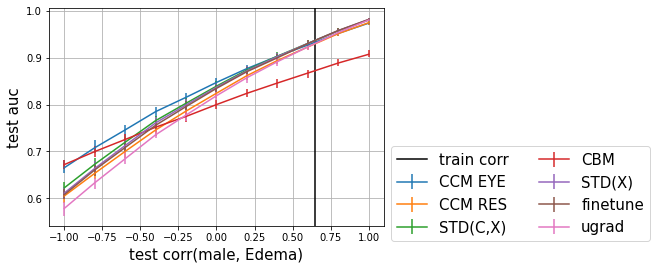

In [37]:
# plot result
def plot_results(results, method_name, key, display_x=lambda x: x):
    x = sorted(results[method_name].keys())
    values = np.array([results[method_name][x_][key] for x_ in x]) # (n, 3)
    y = values[:, 1]
    yerr = np.vstack([y - values[:, 0], values[:, 2] - y])
    x_display = [display_x(x_) for x_ in x]
    plt.errorbar(x_display, y, yerr=yerr, label=method_name)
        
def get_results_transpose(results, method_names, keys):
    '''
    change from (keys, train corr) to  (train corr, keys)
    '''
    tresults = {m: defaultdict(dict) for m in method_names} # results[method][x][key]
    for method_name in method_names:
        x = sorted(results[method_name].keys())
        for k in keys:
            for x_ in x:
                tresults[method_name][float(k)][x_] = results[method_name][x_][k]
                
    return tresults

tresults = get_results_transpose(results, methods, ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
train_corr_display_x =lambda x: subsample_gender(m.df, x)[['is_male', task]].corr().iloc[0, 1]
test_corr_display_x = lambda x: (x-0.5) * 2

for key in [0.8]:
    xlabel = f"test corr(male, {task})"
    plot_results(tresults, 'CCM EYE', key, test_corr_display_x)
    plot_results(tresults, 'CCM RES', key, test_corr_display_x)
    plot_results(tresults, 'STD(C,X)', key, test_corr_display_x)
    plot_results(tresults, 'CBM', key, test_corr_display_x)
    plot_results(tresults, 'STD(X)', key, test_corr_display_x)
    plot_results(tresults, 'finetune', key, test_corr_display_x)
    plot_results(tresults, 'ugrad', key, test_corr_display_x)

    tr_corr = train_corr_display_x(key)
    plt.axvline(tr_corr, color='k', label="train corr")
    plt.ylabel(f'test auc', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15, ncol=2, bbox_to_anchor=(1, 0.4))
    plt.grid()
    # plt.savefig(f'figures/mimic_exclude_a2_finetune_tr{tr_corr:.2f}.png')
    plt.show()

# Regularization comparison


$Y = a C + b U$, $S = d C + e U$, then $\hat{Y} = (a-dt) C + (b-et) U + t S$, where $t \in \mathbb{R}$

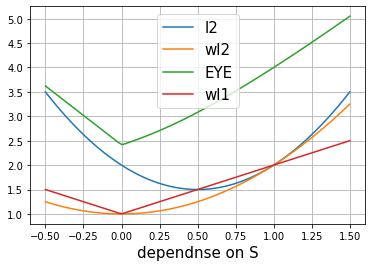

In [49]:
a = 1
b = 1
d = 1
e = 0

x = np.linspace(-0.5, 1.5, 100)
wc = a - d * x
wu = b - e * x
ws = x

def l2(c, u, s):
    return c**2 + u**2 + s**2

def wl2(c, u, s):
    return u**2 + s**2
  
def EYE(c, u, s):
    rl1 = np.abs(u) + np.abs(s)
    return rl1 + np.sqrt(rl1**2 + c**2)

def wl1(c, u, s):
    return np.abs(u) + np.abs(s)
    
plt.plot(x, l2(wc, wu, ws), label='l2')
plt.plot(x, wl2(wc, wu, ws), label='wl2')
plt.plot(x, EYE(wc, wu, ws), label='EYE')
plt.plot(x, wl1(wc, wu, ws), label='wl1')
plt.grid()
plt.xlabel('dependnse on S', fontsize=15)
plt.legend(fontsize=15)


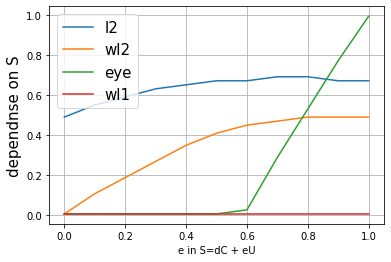

In [50]:
a = 1
b = 1
d = 1
methods = {
    'l2': l2,
    'wl2': wl2,
    'eye': EYE,
    'wl1': wl1
}

x = np.linspace(-0.5, 1.5, 100)
results = dict((method,[]) for method in methods.keys())
e_range = np.linspace(0, 1, 11)
for e in e_range:
    wc = a - d * x
    wu = b - e * x
    ws = x
        
    for method in methods.keys():
        results[method].append(x[np.argmin(methods[method](wc, wu, ws))])
    # results['l2'].append(x[np.argmin(l2(wc, wu, ws))])
    # results['wl2'].append(x[np.argmin(wl2(wc, wu, ws))])
    # results['eye'].append(x[np.argmin(EYE(wc, wu, ws))])
    
for method in results.keys():
    plt.plot(e_range, results[method], label=method)
plt.grid()
plt.ylabel('dependnse on S', fontsize=15)
plt.xlabel('e in S=dC + eU')
plt.legend(fontsize=15)

    
